In [57]:
#OS = MACOS-M1
#Before running the program on jupiter, I run the following codes in terminal first.

## Install Homebrew
##>>>>  /bin/bash -c "$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)"

# Install OpenJDK
##>>>> brew install openjdk

#Install
#>>>>>brew install libomp


#User: Shazisaremi
#Published: April, 2022 
#Title: BDA601
#Link: https://github.com/Shazisaremi/BDA601


!pip install plotly
!pip install lightgbm
!pip install -U scikit-learn scipy matplotlib
!{sys.executable} -m pip install xgboost
!pip install optuna


#import necessary packages

import sys #for graphs
import optuna #for using with any ML or DL framework.
import plotly #for graphs


import numpy as np #for array prossesing
import pandas as pd  #Panda is python librariy is similar to pyspark for managing data frame
import xgboost as xgb #forimporting data from a variety of data formats.
import seaborn as sns  #Seaborn will help us to make colourful graphs
#import lightgbm as lgb
import plotly.express as px #It has features for creating whole figures at once.
import matplotlib.pyplot as plt #for figures and graphs


from pathlib import Path #importing a data file into pandas DataFrame
from pyspark.sql import SparkSession #SparkSession could be used to generate DataFrames, register DataFrames as tables, conduct SQL queries over tables, cache tables, and read parquet files.
from pyspark.sql import functions as func #for built-in functions available for DataFrame. Because we want to use functions like sum, count
from pyspark.sql.types import IntegerType, DoubleType, StringType, FloatType
from pyspark.ml.classification import DecisionTreeClassifier #PySpark MLlib API provides a DecisionTreeClassifier model to implement classification with decision tree method
from pyspark.ml.feature import StringIndexer, VectorAssembler #VectorAssembler is a converter that turns a collection of columns into such a supervector column.
from xgboost import XGBClassifier #It is a decision tree solution developed for machine learning 
from sklearn.preprocessing import LabelEncoder # I will use it for normalize and transform labels for my decision tree classification.
from sklearn.model_selection import train_test_split ,KFold,StratifiedKFold #Provides train/test indices for dividing data into train and test sets.
from sklearn.ensemble import ExtraTreesClassifier #It will increase predicted accuracy and reduce over-fitting.
from sklearn.metrics import classification_report ,confusion_matrix,ConfusionMatrixDisplay #To assess the accuracy of a categorisation, calculate a confusion matrix.
from sklearn.metrics import roc_curve, auc ,roc_auc_score


#create spark context
sqlCtx = SparkSession.builder.getOrCreate()



In [58]:
#First of all i would like to mantion that I could have dropped unneccessery columns by using below codes:
    
#df = pd.read_csv("data.csv")
#df.drop(columns = ['customerID'], axis=1, inplace=True)
#df.drop(columns = ['MonthlyCharges'], axis=1, inplace=True)
#df.drop(columns = ['OnlineSecurity'], axis=1, inplace=True)
#df.drop(columns = ['StreamingTV'], axis=1, inplace=True)
#df.drop(columns = ['InternetService'], axis=1, inplace=True)
#df.drop(columns = ['Partner'], axis=1, inplace=True)

#df.head()

#But thanks to Excel, i modified and remove unneceserry 
#attributes by using excel before starting my code as per the assignment requirement.

In [59]:
telco = sqlCtx.read.option('header','true').csv('telco.csv',)
telco.show()

+----------+------+-------------+----------+------+------------+----------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+------------+-----+
|customerID|gender|SeniorCitizen|Dependents|tenure|PhoneService|   MultipleLines|       OnlineBackup|   DeviceProtection|        TechSupport|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|TotalCharges|Churn|
+----------+------+-------------+----------+------+------------+----------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+------------+-----+
|7590-VHVEG|Female|            0|        No|     1|          No|No phone service|                Yes|                 No|                 No|                 No|Month-to-month|             Yes|    Electronic check|       29.85|   No|
|5575-GNVDE|  Male|            0|        No|    34|         Yes|

In [60]:
#The contract term of the customer (Month-to-month, One year, Two year) 
#I wanted to see that which contract has been used by count of users.
#Here i stated to get idea about data and firstly i thought Contract 
#is the most poverful feature to prevent customer churn.
#in this list i can identify the problem based on the Contract.
#The customers needs to stay longer to reduce the churn.

telco.groupby(telco.Contract).count().orderBy("count").show(truncate=False)

+--------------+-----+
|Contract      |count|
+--------------+-----+
|One year      |1473 |
|Two year      |1695 |
|Month-to-month|3875 |
+--------------+-----+



In [61]:
#The Payment Method attribute of the customer (Credit card, Bank transfer, Mailed check, Electronic check) 
#i wanted to see that which has been used by count of users.

telco.groupby(telco.PaymentMethod).count().orderBy("count").show(truncate=False)

+-------------------------+-----+
|PaymentMethod            |count|
+-------------------------+-----+
|Credit card (automatic)  |1522 |
|Bank transfer (automatic)|1544 |
|Mailed check             |1612 |
|Electronic check         |2365 |
+-------------------------+-----+



In [62]:
telco.groupby(telco.tenure).count().orderBy("count").show(truncate=False)

+------+-----+
|tenure|count|
+------+-----+
|0     |11   |
|36    |50   |
|44    |51   |
|39    |56   |
|28    |57   |
|38    |59   |
|59    |60   |
|45    |61   |
|21    |63   |
|48    |64   |
|55    |64   |
|33    |64   |
|40    |64   |
|31    |65   |
|37    |65   |
|57    |65   |
|34    |65   |
|42    |65   |
|43    |65   |
|49    |66   |
+------+-----+
only showing top 20 rows



In [63]:
telco.groupby(telco.Dependents).count().orderBy("count").show(truncate=False)

+----------+-----+
|Dependents|count|
+----------+-----+
|Yes       |2110 |
|No        |4933 |
+----------+-----+



In [64]:
#Tenure attribute shows me that how long customers use TELCO 
#Find which five tenure groups were involved with highest number of customer.
#Insight of tenure attribute shows customer satisfaction to stay in same company. 
#The result shows 362 customer is the longer users while 613 customer is just sign in. 


tenure = telco.where((telco.tenure > 0)).groupby(telco.tenure.cast(IntegerType()))\
.count().orderBy("count", ascending=False).limit(5)
tenure.show(truncate=False)

+-------------------+-----+
|CAST(tenure AS INT)|count|
+-------------------+-----+
|1                  |613  |
|72                 |362  |
|2                  |238  |
|3                  |200  |
|4                  |176  |
+-------------------+-----+



In [65]:
#The supplied schema is automatically inferred using the inferSchema function. 
#It necessitates one more pass over the data. False is used as the default value if None is set.

telco_data = sqlCtx.read.option('header','true').csv('telco.csv', inferSchema =True)

telco_data.show()
telco_data.dtypes


+----------+------+-------------+----------+------+------------+----------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+------------+-----+
|customerID|gender|SeniorCitizen|Dependents|tenure|PhoneService|   MultipleLines|       OnlineBackup|   DeviceProtection|        TechSupport|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|TotalCharges|Churn|
+----------+------+-------------+----------+------+------------+----------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+------------+-----+
|7590-VHVEG|Female|            0|        No|     1|          No|No phone service|                Yes|                 No|                 No|                 No|Month-to-month|             Yes|    Electronic check|       29.85|   No|
|5575-GNVDE|  Male|            0|        No|    34|         Yes|

[('customerID', 'string'),
 ('gender', 'string'),
 ('SeniorCitizen', 'int'),
 ('Dependents', 'string'),
 ('tenure', 'int'),
 ('PhoneService', 'string'),
 ('MultipleLines', 'string'),
 ('OnlineBackup', 'string'),
 ('DeviceProtection', 'string'),
 ('TechSupport', 'string'),
 ('StreamingMovies', 'string'),
 ('Contract', 'string'),
 ('PaperlessBilling', 'string'),
 ('PaymentMethod', 'string'),
 ('TotalCharges', 'string'),
 ('Churn', 'string')]

In [66]:
telco_data.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [67]:
telco_data.head(5)

[Row(customerID='7590-VHVEG', gender='Female', SeniorCitizen=0, Dependents='No', tenure=1, PhoneService='No', MultipleLines='No phone service', OnlineBackup='Yes', DeviceProtection='No', TechSupport='No', StreamingMovies='No', Contract='Month-to-month', PaperlessBilling='Yes', PaymentMethod='Electronic check', TotalCharges='29.85', Churn='No'),
 Row(customerID='5575-GNVDE', gender='Male', SeniorCitizen=0, Dependents='No', tenure=34, PhoneService='Yes', MultipleLines='No', OnlineBackup='No', DeviceProtection='Yes', TechSupport='No', StreamingMovies='No', Contract='One year', PaperlessBilling='No', PaymentMethod='Mailed check', TotalCharges='1889.5', Churn='No'),
 Row(customerID='3668-QPYBK', gender='Male', SeniorCitizen=0, Dependents='No', tenure=2, PhoneService='Yes', MultipleLines='No', OnlineBackup='Yes', DeviceProtection='No', TechSupport='No', StreamingMovies='No', Contract='Month-to-month', PaperlessBilling='Yes', PaymentMethod='Mailed check', TotalCharges='108.15', Churn='Yes'),


In [68]:
#Calculate the mean, median and standard deviation of all the variables/attributes of numeric type; 
#Here is i selected most
#important attributes for my point of veiw for now.

telco_data.select('Contract', 'PaymentMethod', 'SeniorCitizen', 'TechSupport', 'TotalCharges', 'tenure').describe().show()
telco_data.groupby(telco_data.Churn).agg(func.mean("Contract"), func.mean("PaymentMethod"), func.mean("SeniorCitizen"), func.mean("TechSupport"), func.mean("TotalCharges"), func.mean("tenure")).show()
telco_data.groupby(telco_data.Churn).mean().show()


+-------+--------------+--------------------+------------------+-----------+------------------+------------------+
|summary|      Contract|       PaymentMethod|     SeniorCitizen|TechSupport|      TotalCharges|            tenure|
+-------+--------------+--------------------+------------------+-----------+------------------+------------------+
|  count|          7043|                7043|              7043|       7043|              7043|              7043|
|   mean|          null|                null|0.1621468124378816|       null|2283.3004408418697| 32.37114865824223|
| stddev|          null|                null|0.3686116056100135|       null| 2266.771361883145|24.559481023094442|
|    min|Month-to-month|Bank transfer (au...|                 0|         No|                  |                 0|
|    max|      Two year|        Mailed check|                 1|        Yes|             999.9|                72|
+-------+--------------+--------------------+------------------+-----------+----

In [69]:
telco_data.select('TotalCharges', 'tenure').describe().show()

+-------+------------------+------------------+
|summary|      TotalCharges|            tenure|
+-------+------------------+------------------+
|  count|              7043|              7043|
|   mean|2283.3004408418697| 32.37114865824223|
| stddev| 2266.771361883145|24.559481023094442|
|    min|                  |                 0|
|    max|             999.9|                72|
+-------+------------------+------------------+



In [70]:
#end of my little analyse i wanted to see the data of customer churn to make sure about problem statement.
telco_data.groupBy('Churn').count().show()

+-----+-----+
|Churn|count|
+-----+-----+
|   No| 5174|
|  Yes| 1869|
+-----+-----+



# Exploratory Data Analysis

## Here, I visualized the data to get an idea about the atteibutes. Accordingly, I will be able to predict the outline of the features to be selected.

### Selected data for now;
#### Tenure
#### Contract
#### PaymentMethod
#### TotalCharges
#### TechSupport

### 1-For each data, the components in the data will be counted in this section.
### 2-Then a graph will be created accordingly. This created graph and count will determine which component of this feature is used more.
### 3-As a final step, we will look at the importance of the data according to the churn analysis for churn analysis. By seeing the churn values of the components, we will find out which component is more important based on choosen veriables.

#### Thus, we will see which component or feature of TELCO company should pay attention to.

+------+-----+
|tenure|count|
+------+-----+
|    31|   65|
|    65|   76|
|    53|   70|
|    34|   65|
|    28|   57|
|    27|   72|
|    26|   79|
|    44|   51|
|    12|  117|
|    22|   90|
|    47|   68|
|     1|  613|
|    52|   80|
|    13|  109|
|    16|   80|
|     6|  110|
|     3|  200|
|    20|   71|
|    40|   64|
|    57|   65|
+------+-----+
only showing top 20 rows

        count  mean   std  min   25%   50%   75%   max
Churn                                                 
No     5174.0  38.0  24.0  0.0  15.0  38.0  61.0  72.0
Yes    1869.0  18.0  20.0  1.0   2.0  10.0  29.0  72.0


/Users/nilayaltinay/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



Text(0.5, 0, 'Tenure (months)')

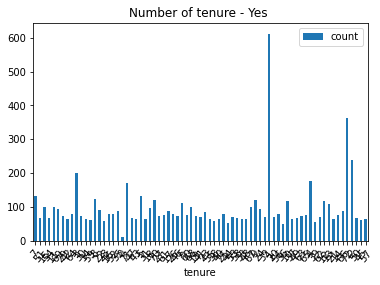

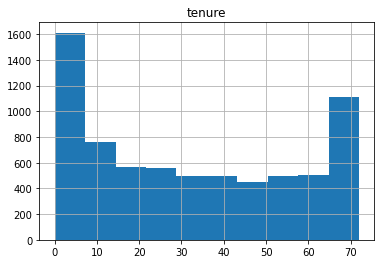

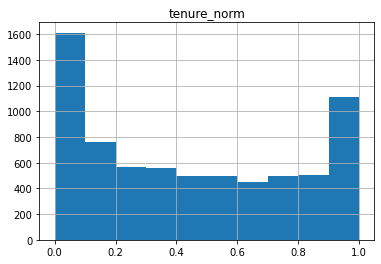

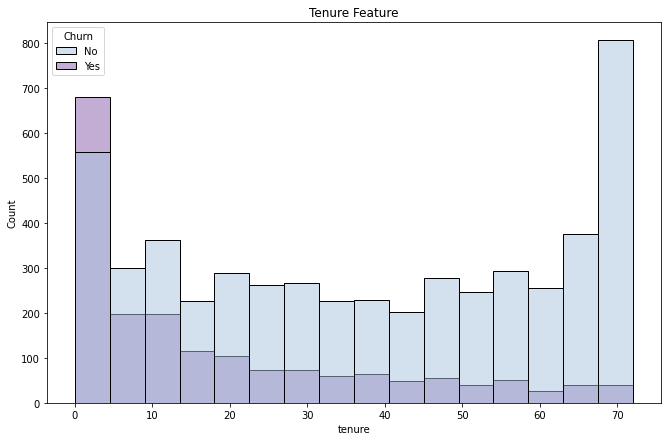

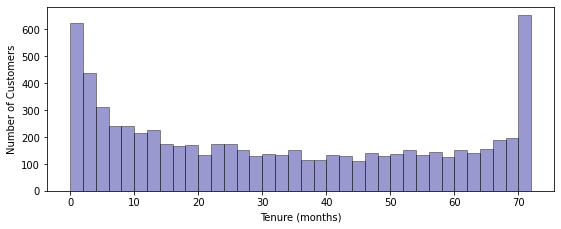

In [71]:
#TENURE DATA

#COUNTING TENURE ATTRIBUTEc
telco_data.groupBy('tenure').count().show()


#CREATING TENURE BAR GRAPHT 
#Unfortunately, the result obtained from this graph is not sufficient.
df = telco.groupby('tenure').count()
df.toPandas().plot.bar(x="tenure", y="count", rot=50, title="Number of tenure - Yes ");


### CREATEING TENURE histogram
df = telco_data.select("tenure")
df_tenure = df.toPandas()#convert pyspark dataframe to Pandas dataframe here for histogram
df_tenure.hist(column = "tenure")


# Create a histogram of the **normalised** variable/attribute: TENURE
df_normal = df.toPandas()
df_normal["tenure_norm"] = (df_normal["tenure"] - df_normal["tenure"].min()) / (df_normal["tenure"].max() - df_normal["tenure"].min())
df_normal.hist(column="tenure_norm")


#CREATING BAR GRAPH BASED ON CHURN BY TENURE
data = pd.read_csv("telco.csv")
plt.figure(figsize=(11,7))
sns.histplot(data=data,x="tenure",hue='Churn', palette='BuPu')
plt.title('Tenure Feature')


#Statistics on churn x tenure
df = pd.read_csv("telco.csv")
print(df.groupby('Churn').tenure.describe().round(0))
# Visualizing how churn interacts with tenure
fig = px.box(df, x = 'tenure', y = 'Churn', template = 'seaborn',
            title = 'Churn x Tenure')
fig.show()


#number of customer based on tenure mountly rate
plt.figure(figsize=(20,40))
plt.subplot(10,2,1)
#defining axis details.
ax = sns.distplot(data['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure (months)')



+------------+-----+
|TotalCharges|count|
+------------+-----+
|      3437.5|    1|
|     1612.75|    1|
|       483.7|    1|
|      1756.6|    1|
|     2633.95|    1|
+------------+-----+
only showing top 5 rows



Text(0.5, 1.0, 'TotalCharges Feature')

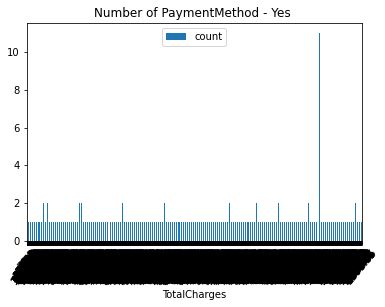

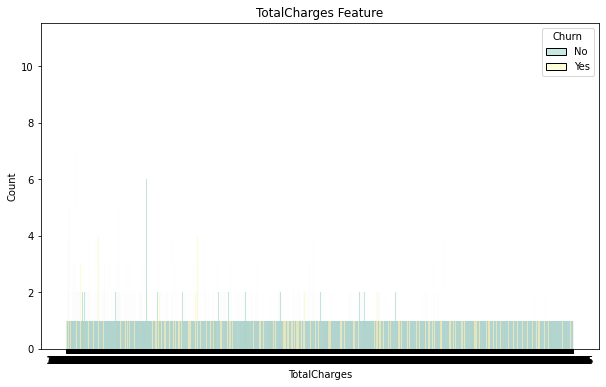

In [72]:
#TOTAL CHARGES DATA

#COUNTING PAYMENT METHOD ATTRIBUTE
telco_data.groupBy('TotalCharges').count().show(5) #this information doesn't show us much of a way here. Because everyone's bill will be different.

#CREATING TotalCharges BAR GRAPHT 
df = telco.groupby('TotalCharges').count()
df.toPandas().plot.bar(x="TotalCharges", y="count", rot=50, title="Number of PaymentMethod - Yes ");


#CREATING BAR GRAPH BASED ON CHURN BY TOTAL CHARGES
plt.figure(figsize=(10,6))
sns.histplot(data=data,x="TotalCharges",hue='Churn', palette='Set3')
plt.title('TotalCharges Feature')



+--------------+-----+
|      Contract|count|
+--------------+-----+
|Month-to-month| 3875|
|      One year| 1473|
|      Two year| 1695|
+--------------+-----+



Text(0.5, 1.0, 'Contract Feature')

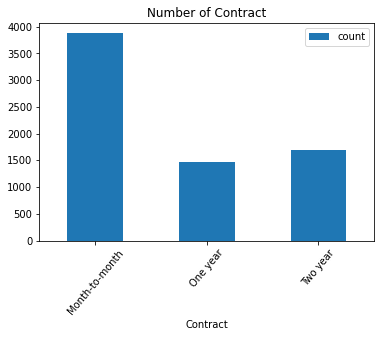

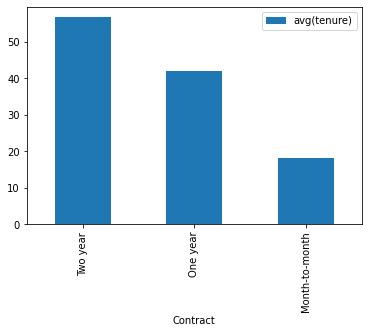

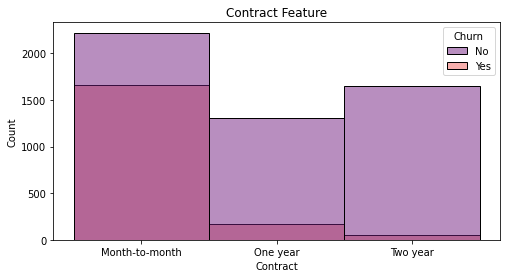

In [73]:
#CONTRACT DATA

#COUNTING CONTRACT ATTRIBUTE
telco_data.groupBy('Contract').count().show()


#CREATING CONTRACT BAR GRAPHT 
df = telco.groupby('Contract').count()
df.toPandas().plot.bar(x="Contract", y="count", rot=50, title="Number of Contract");


#BIN THE VARIBLA ATTIBUTE TENURE AND CREATE A BAR CHART
df = telco_data.groupBy('Contract').agg(func.mean("tenure")).orderBy("avg(tenure)", ascending=False)
df.toPandas().plot.bar(x="Contract", y="avg(tenure)")


#CREATING BAR GRAPH BASED ON CHURN BY CONTRACT
plt.figure(figsize=(8,4))
sns.histplot(data=data,x="Contract",hue='Churn', palette='magma')
plt.title('Contract Feature')



+--------------------+-----+
|       PaymentMethod|count|
+--------------------+-----+
|Credit card (auto...| 1522|
|        Mailed check| 1612|
|Bank transfer (au...| 1544|
|    Electronic check| 2365|
+--------------------+-----+



Text(0.5, 1.0, 'PaymentMethod Feature')

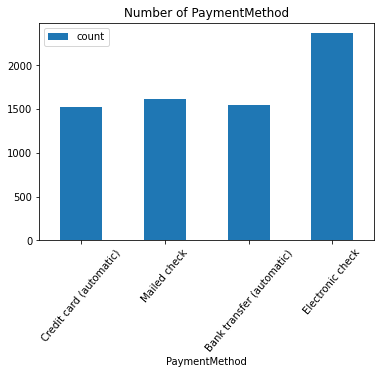

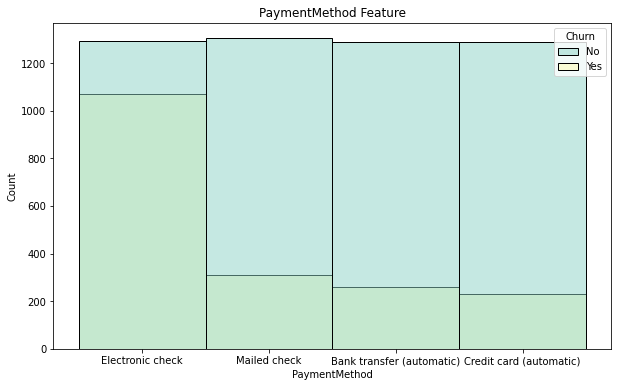

In [74]:
#PAYMENT METHOD DATA


#COUNTING PAYMENT METHOD ATTRIBUTE
telco_data.groupBy('PaymentMethod').count().show()


#CREATING PAYMENT METHOD BAR GRAPHT 
df = telco.groupby('PaymentMethod').count()
df.toPandas().plot.bar(x="PaymentMethod", y="count", rot=50, title="Number of PaymentMethod");

#CREATING BAR GRAPH BASED ON CHURN BY PAYMENT MEHOD
plt.figure(figsize=(10,6))
sns.histplot(data=data,x="PaymentMethod",hue='Churn', palette='Set3')
plt.title('PaymentMethod Feature')

+-------------------+-----+
|        TechSupport|count|
+-------------------+-----+
|                 No| 3473|
|                Yes| 2044|
|No internet service| 1526|
+-------------------+-----+

        count  mean   std  min   25%   50%   75%   max
Churn                                                 
No     5174.0  38.0  24.0  0.0  15.0  38.0  61.0  72.0
Yes    1869.0  18.0  20.0  1.0   2.0  10.0  29.0  72.0


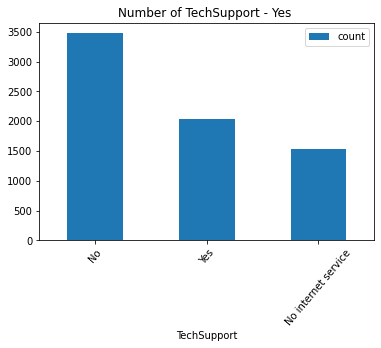

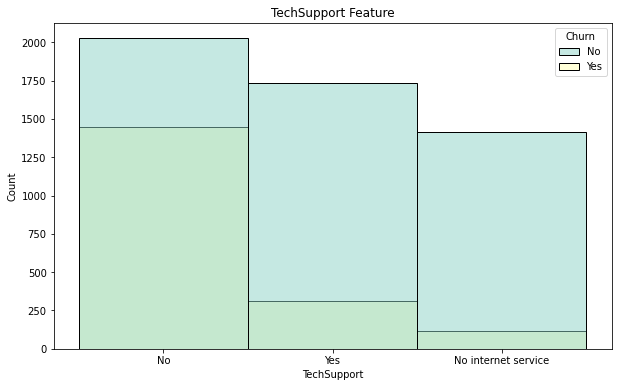

In [75]:
#TechSupport DATA

#COUNTING TechSupport ATTRIBUTE
telco_data.groupBy('TechSupport').count().show()

#CREATING TechSupport BAR GRAPHT 
df = telco.groupby('TechSupport').count()
df.toPandas().plot.bar(x="TechSupport", y="count", rot=50, title="Number of TechSupport - Yes ");



#CREATING BAR GRAPH BASED ON CHURN BY TechSupport
plt.figure(figsize=(10,6))
sns.histplot(data=data,x="TechSupport",hue='Churn', palette='Set3')
plt.title('TechSupport Feature')


#Statistics on churn x TechSupport
df = pd.read_csv("telco.csv")
print(df.groupby('Churn').tenure.describe().round(0))


# Creating different types of visuals to insigt about the data

array([[<AxesSubplot:title={'center':'SeniorCitizen'}>]], dtype=object)

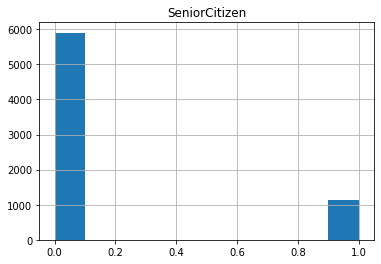

In [76]:
# Create a histogram of the **normalised** variable/attribute: SeniorCitizen
df = telco_data.select("SeniorCitizen")

df_SeniorCitizen = df.toPandas()
df_SeniorCitizen.hist(column = "SeniorCitizen")

array([[<AxesSubplot:title={'center':'SeniorCitizen_norm'}>]],
      dtype=object)

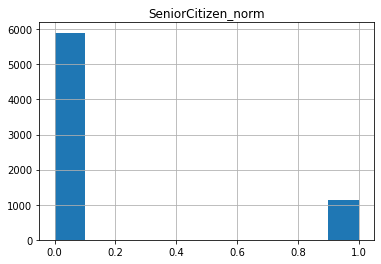

In [77]:
# Create a histogram of the **normalised** variable/attribute: SeniorCitizen

df_normal = df.toPandas()
df_normal["SeniorCitizen_norm"] = (df_normal["SeniorCitizen"] - df_normal["SeniorCitizen"].min()) / (df_normal["SeniorCitizen"].max() - df_normal["SeniorCitizen"].min())
df_normal.hist(column="SeniorCitizen_norm")

<AxesSubplot:xlabel='Contract'>

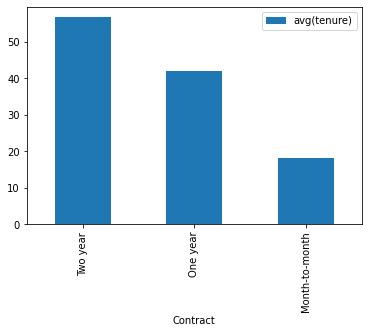

In [78]:
df = telco_data.groupBy('Contract').avg().orderBy("avg(tenure)", ascending = False)

#Convert pyspark dataframe to Pandas dataframe for bar chart
df_tenure = df.toPandas()

df_tenure.plot.bar(x='Contract', y='avg(tenure)')

<AxesSubplot:xlabel='Contract'>

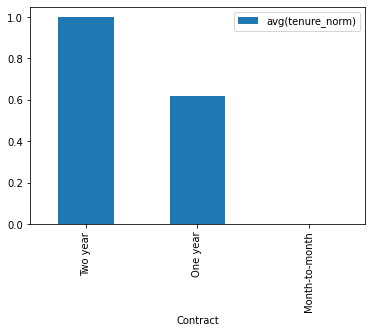

In [79]:

#Convert pyspark dataframe tp Pandas dataframe here for normalization

df_normal = df.toPandas()

#First we create one column and we named it as sum(previous)_norm as a veriable to store normalization value there

df_normal["avg(tenure_norm)"] = (df_normal["avg(tenure)"] - df_normal["avg(tenure)"].min()) / (df_normal["avg(tenure)"].max() - df_normal["avg(tenure)"].min())

df_normal.plot.bar(x='Contract', y='avg(tenure_norm)')

In [80]:
#df = telco_data.select("tenure", "TotalCharges")

#df_scatter = df.toPandas()

#df_scatter.plot.scatter(x="tenure", y="TotalCharges")

<AxesSubplot:xlabel='Contract'>

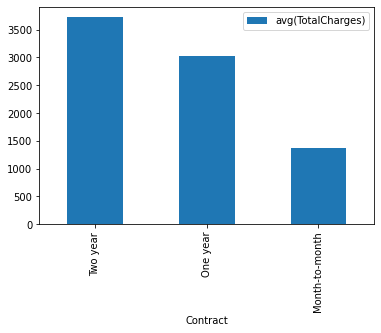

In [81]:
df = telco_data.groupBy('Contract').agg(func.mean("TotalCharges")).orderBy("avg(TotalCharges)", ascending=False)
df.toPandas().plot.bar(x="Contract", y="avg(TotalCharges)")

<AxesSubplot:xlabel='Contract'>

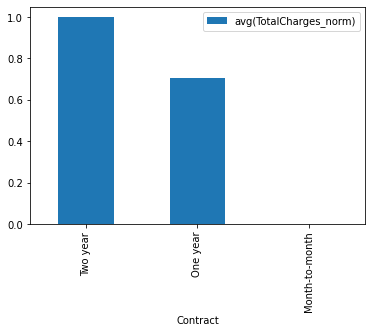

In [82]:
df_normal = df.toPandas()

#First we create one column and we named it as sum(TotalCharges)_norm as a veriable to store normalization value there

df_normal["avg(TotalCharges_norm)"] = (df_normal["avg(TotalCharges)"] - df_normal["avg(TotalCharges)"].min()) / (df_normal["avg(TotalCharges)"].max() - df_normal["avg(TotalCharges)"].min())

df_normal.plot.bar(x='Contract', y='avg(TotalCharges_norm)')

<AxesSubplot:xlabel='TechSupport'>

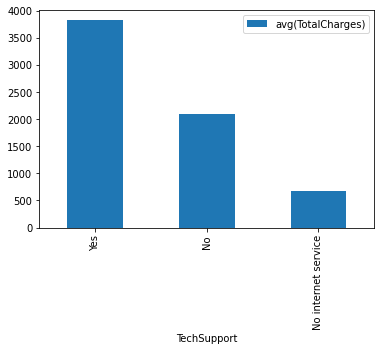

In [83]:
df = telco_data.groupBy('TechSupport').agg(func.mean("TotalCharges")).orderBy("avg(TotalCharges)", ascending=False)
df.toPandas().plot.bar(x="TechSupport", y="avg(TotalCharges)")

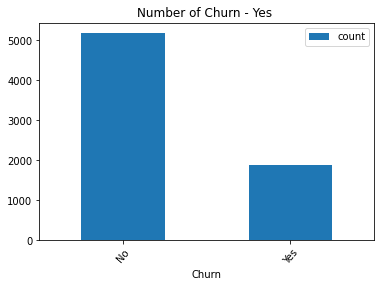

In [84]:
df = telco.groupby('Churn').count()

df.toPandas().plot.bar(x="Churn", y="count", rot=50, title="Number of Churn - Yes ");

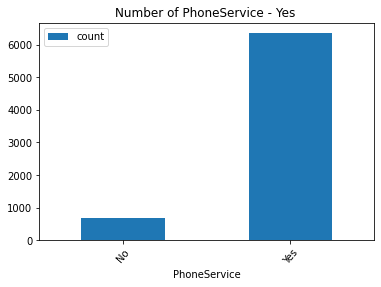

In [85]:
df = telco.groupby('PhoneService').count()

df.toPandas().plot.bar(x="PhoneService", y="count", rot=50, title="Number of PhoneService - Yes ");

Text(0.5, 1.0, 'Dependents feature')

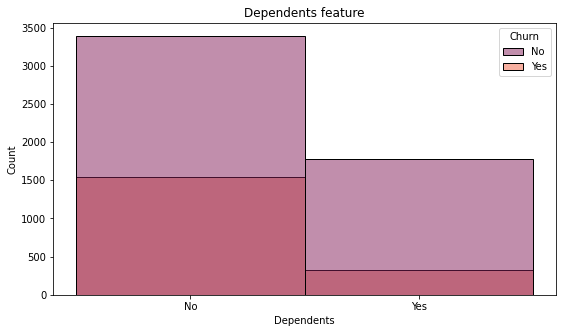

In [86]:
#Dependencies attribute
#Whether a customer is a dependent or not is indicated by the binary variable in the Dependents feature. 
#turnover is pretty common in both groups, and we can observe that the majority of consumers are not reliant.

plt.figure(figsize=(9,5))
#using sns function to create graph and defining the axises and graph colors
sns.histplot(data=data,x="Dependents",hue='Churn', palette='rocket')
plt.title('Dependents feature')

In [87]:
# https://www.kaggle.com/code/gauravduttakiit/telecom-churn-case-study-with-decision-tree/notebook

## MISSING VALUES

In [88]:

#User: LIKHIT JHA 
#Published: July 8 2022
#Title: Customer Churn
#Link: https://www.kaggle.com/code/likhitjha/customer-churn

In [89]:
#defining the dataframe as my csv file
df = pd.read_csv("telco.csv")
df.head()

,customerID,gender,SeniorCitizen,Dependents,tenure,PhoneService,MultipleLines,OnlineBackup,DeviceProtection,TechSupport,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,TotalCharges,Churn
0,7590-VHVEG,Female,0,No,1,No,No phone service,Yes,No,No,No,Month-to-month,Yes,Electronic check,29.85,No
1,5575-GNVDE,Male,0,No,34,Yes,No,No,Yes,No,No,One year,No,Mailed check,1889.5,No
2,3668-QPYBK,Male,0,No,2,Yes,No,Yes,No,No,No,Month-to-month,Yes,Mailed check,108.15,Yes
3,7795-CFOCW,Male,0,No,45,No,No phone service,No,Yes,Yes,No,One year,No,Bank transfer (automatic),1840.75,No
4,9237-HQITU,Female,0,No,2,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,151.65,Yes


In [90]:
#Here we are printing our data information based on column, data type etc..
print("dataset shape  : ",df.shape)
print("dataset rows   : ",df.shape[0])
print("dataset columns: ",df.shape[1])
print("dataset size   : ",df.size)
print(df.info())

dataset shape  :  (7043, 16)
dataset rows   :  7043
dataset columns:  16
dataset size   :  112688
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   gender            7043 non-null   object
 2   SeniorCitizen     7043 non-null   int64 
 3   Dependents        7043 non-null   object
 4   tenure            7043 non-null   int64 
 5   PhoneService      7043 non-null   object
 6   MultipleLines     7043 non-null   object
 7   OnlineBackup      7043 non-null   object
 8   DeviceProtection  7043 non-null   object
 9   TechSupport       7043 non-null   object
 10  StreamingMovies   7043 non-null   object
 11  Contract          7043 non-null   object
 12  PaperlessBilling  7043 non-null   object
 13  PaymentMethod     7043 non-null   object
 14  TotalCharges      7043 non-null   object
 15  Churn   

In [91]:
#Printing the churn value one more time to see churn value count
print('Churn :')
print(df['Churn'].value_counts())

Churn :
No     5174
Yes    1869
Name: Churn, dtype: int64


In [92]:
#printing missing values by using isnull function
print(df.isnull().sum())
print()
print("Missing values = ",df.isnull().sum().sum())

customerID          0
gender              0
SeniorCitizen       0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
TotalCharges        0
Churn               0
dtype: int64

Missing values =  0


In [93]:
#printing data types
df.dtypes

customerID          object
gender              object
SeniorCitizen        int64
Dependents          object
tenure               int64
PhoneService        object
MultipleLines       object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingMovies     object
Contract            object
PaperlessBilling    object
PaymentMethod       object
TotalCharges        object
Churn               object
dtype: object

In [94]:
#Here I choose only Total Charges attribute the see if there is any missing value. Because when i went throug csv file
#I just caught 1 cell that it does not have any input. Thats why i decided to see. 
#with the help of the panda library here i change totalcharges df into pd numeric.
df['TotalCharges']=pd.to_numeric(df['TotalCharges'],errors='coerce')
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
TotalCharges        11
Churn                0
dtype: int64

<AxesSubplot:>

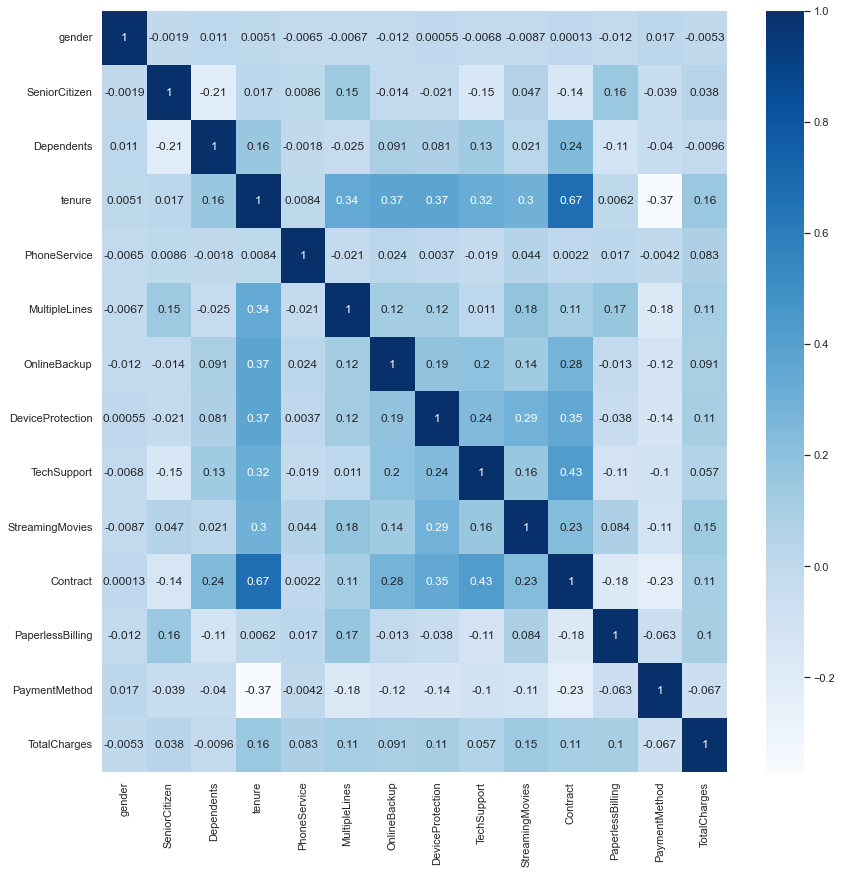

In [131]:

#LINK: https://www.kaggle.com/code/casper6290/telcocustomerchurn

#printing the heatmap of the correlation matrix to see which attributes relatationship between the attributes
#creating figure size
plt.figure(figsize=(14,14))
#defining figure colors and axis.
sns.heatmap(X.corr(),annot=True,cmap='Blues')


In [96]:
#ANOTHER WAY TO SEE CORRELATION MATRIX

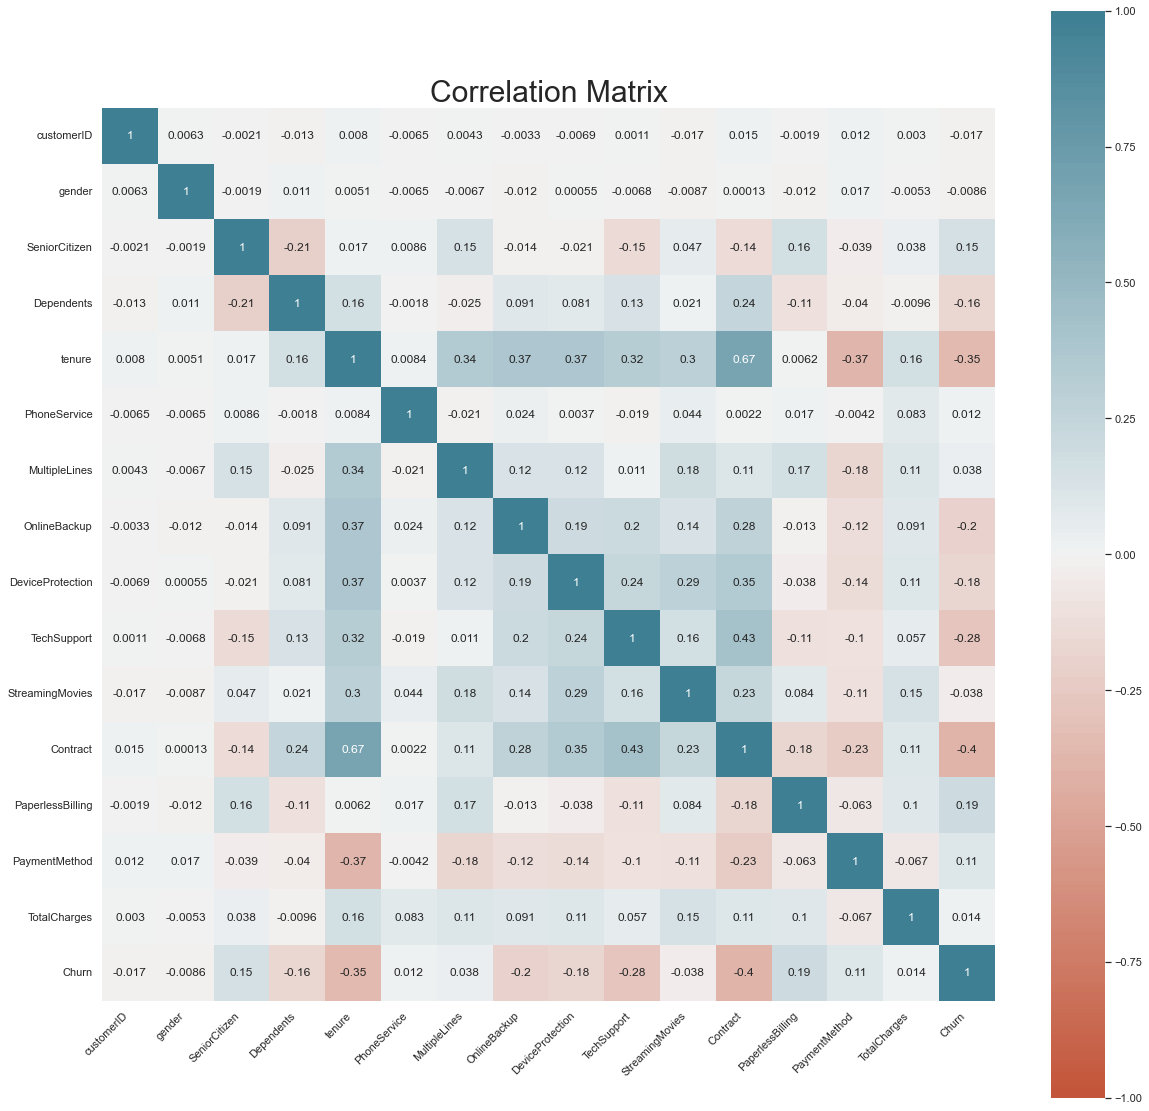

In [97]:
#User: LIKHIT JHA 
#Published: July 8 2022
#Title: Customer Churn
#Link: https://www.kaggle.com/code/likhitjha/customer-churn

str_vars=df.columns[df.dtypes=='object']

labelencoder=LabelEncoder()
for column in df.columns:
    if column in str_vars:
        df[column] = labelencoder.fit_transform(df[column])
df.head()
df_merged=df

sns.set(rc = {'figure.figsize':(20,20)})
corr=df_merged.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

plt.title("Correlation Matrix",size=30)
plt.show()

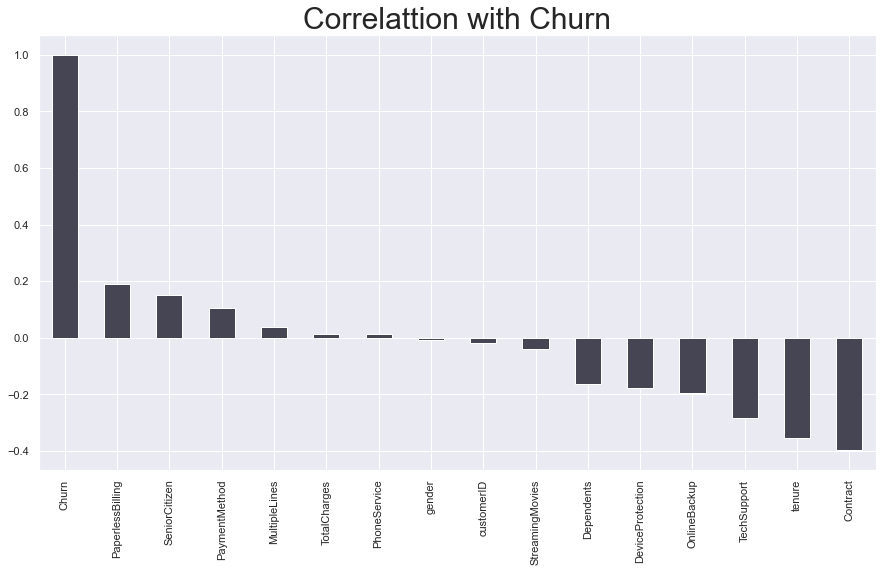

In [98]:
#User: LIKHIT JHA 
#Published: July 8 2022
#Title: Customer Churn
#Link: https://www.kaggle.com/code/likhitjha/customer-churn

#Based on the Correlattion with churn we can see the which attributes is most important for decision tree.
#creating figure size
plt.figure(figsize=(15,8))
colors = ['#454553']
#merging the correlation
df_merged.corr()['Churn'].sort_values(ascending = False).plot(kind = 'bar', color = colors)
#creating tittle
plt.title("Correlattion with Churn",size=30)
plt.show()

# FEATURE IMPORTANCE

In [99]:
#User: ANIBAH
#Published: July 4 2022
#Title: Telecom churn prediction
#Link: https://www.kaggle.com/code/mhslearner/telecom-churn-prediction

# Churn prediction

### Following some data analysis, I will create a model using Xgboost that will allow me to forecast, based on attributes, if the customer is likely to churn within the following month.


#### Data preparation

In [100]:
#User: ANIBAH
#Published: July 4 2022
#Title: Telecom churn prediction
#Link: https://www.kaggle.com/code/mhslearner/telecom-churn-prediction

In [101]:
telco = pd.read_csv("Telco.csv") #reading our csv file with panda

In [102]:
X = telco.drop(columns=['customerID',"Churn"]).copy() #drop ID and target the attribute. 
#Here i wanted to drop CustomerID attribute because i assumed that every customer has uniqe ID.
y = telco["Churn"].copy()

In [103]:
category_col = [col for col in X.columns if X[col].dtype == 'object']
numerical_col = [col for col in X.columns if X[col].dtype == 'int']

In [104]:
# Label encoding is the process of transforming labels into a numerical format so that they may be read by machines. 
#The operation of such labels can then be better determined by ML techniques. 
#It is a significant classification techniques pre-processing stage for the organized data.

label_code = LabelEncoder()
for col in category_col: X[col] = label_code.fit_transform(X[col])

y_code = label_code.fit_transform(y)

In [105]:
## Splitting the data into train and test
#Here we train and test my dataset that i will use for the development of my model.

X_train, X_test, y_train,y_test = train_test_split(X, y_code, test_size=0.2, random_state=42)
print(X_train.shape,X_test.shape, y_train.shape,y_test.shape )

(5634, 14) (1409, 14) (5634,) (1409,)


In [106]:
%%time
splits = 5 # folds number
predictions = [] # list of predictions 
scores = [] # auc_roc validation score 
feat_imp = pd.DataFrame() # get feat importance 
train_x = X_train.values ## i am converting Dataframe to numpy array 
kf =  StratifiedKFold(n_splits=splits, shuffle=True, random_state=42) # here i am creating folds 


###---Training extra trees classifier---### 

for fold, (idx_train, idx_valid) in enumerate(kf.split(train_x,y_train)):
    X_tr, y_tr = train_x[idx_train], y_train[idx_train]
    X_val, y_val = train_x[idx_valid], y_train[idx_valid]
    model =  XGBClassifier(random_state = 42)
    model.fit(X_tr,y_tr)
    val_pred = model.predict_proba(X_val)[:, 1]
    score = roc_auc_score(y_val, val_pred)
    scores.append(score)
    print(f"Fold: {fold + 1} roc_auc Result is : {score}")
    fold_imp= pd.DataFrame()
    fold_imp["Feature"] = X_test.columns
    fold_imp["importance"] = model.feature_importances_
    fold_imp["fold"] = fold+ 1
    feat_imp = pd.concat([feat_imp, fold_imp], axis=0)
    print('*'*40)
    test_preds = model.predict_proba(X_test)[:, 1]
    predictions.append(test_preds)
print(f" mean Validation roc_aucis : {np.mean(scores)}")


Fold: 1 roc_auc Result is : 0.7888755594332154
****************************************
Fold: 2 roc_auc Result is : 0.8079629360347695
****************************************
Fold: 3 roc_auc Result is : 0.8128665600310212
****************************************
Fold: 4 roc_auc Result is : 0.7909290608625554
****************************************
Fold: 5 roc_auc Result is : 0.8118112369729003
****************************************
 mean Validation roc_aucis : 0.8024890706668923
CPU times: user 9.29 s, sys: 1.71 s, total: 11 s
Wall time: 1.9 s


In [107]:
preds = np.array(predictions)
preds = preds.mean(axis=0)
test_score = roc_auc_score(y_test, preds)
test_score

0.8431066071816742

### Feature Importance

#### My features are shown together with their scores under Feature Importance. It conveys the significance of each variable. A higher score denotes a greater impact of the particular attribute on the model.

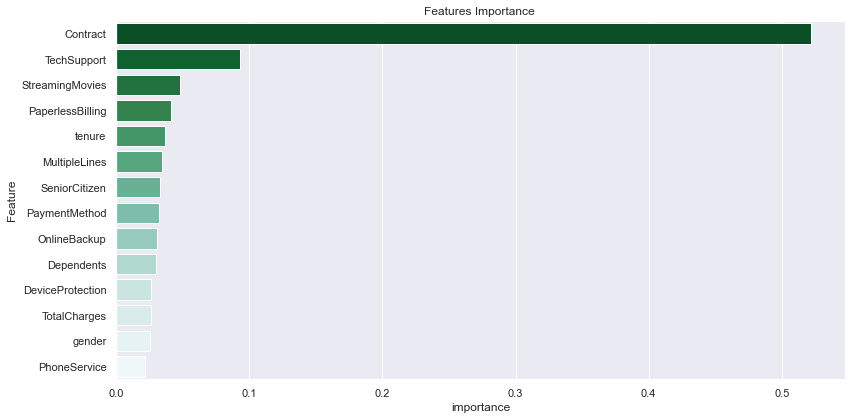

In [108]:
plot =feat_imp.groupby("Feature").mean().reset_index()
plt.figure(figsize=(12,6))
sns.barplot(x="importance", y="Feature", data=plot.sort_values(by="importance", ascending=False),palette = 'BuGn_r')
plt.title('Features Importance ')
plt.tight_layout()
plt.show()

In [109]:
preds=np.around(np.around(preds, decimals=0)) ## round values to 0 and 1 
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1036
           1       0.64      0.49      0.55       373

    accuracy                           0.79      1409
   macro avg       0.73      0.70      0.71      1409
weighted avg       0.78      0.79      0.78      1409



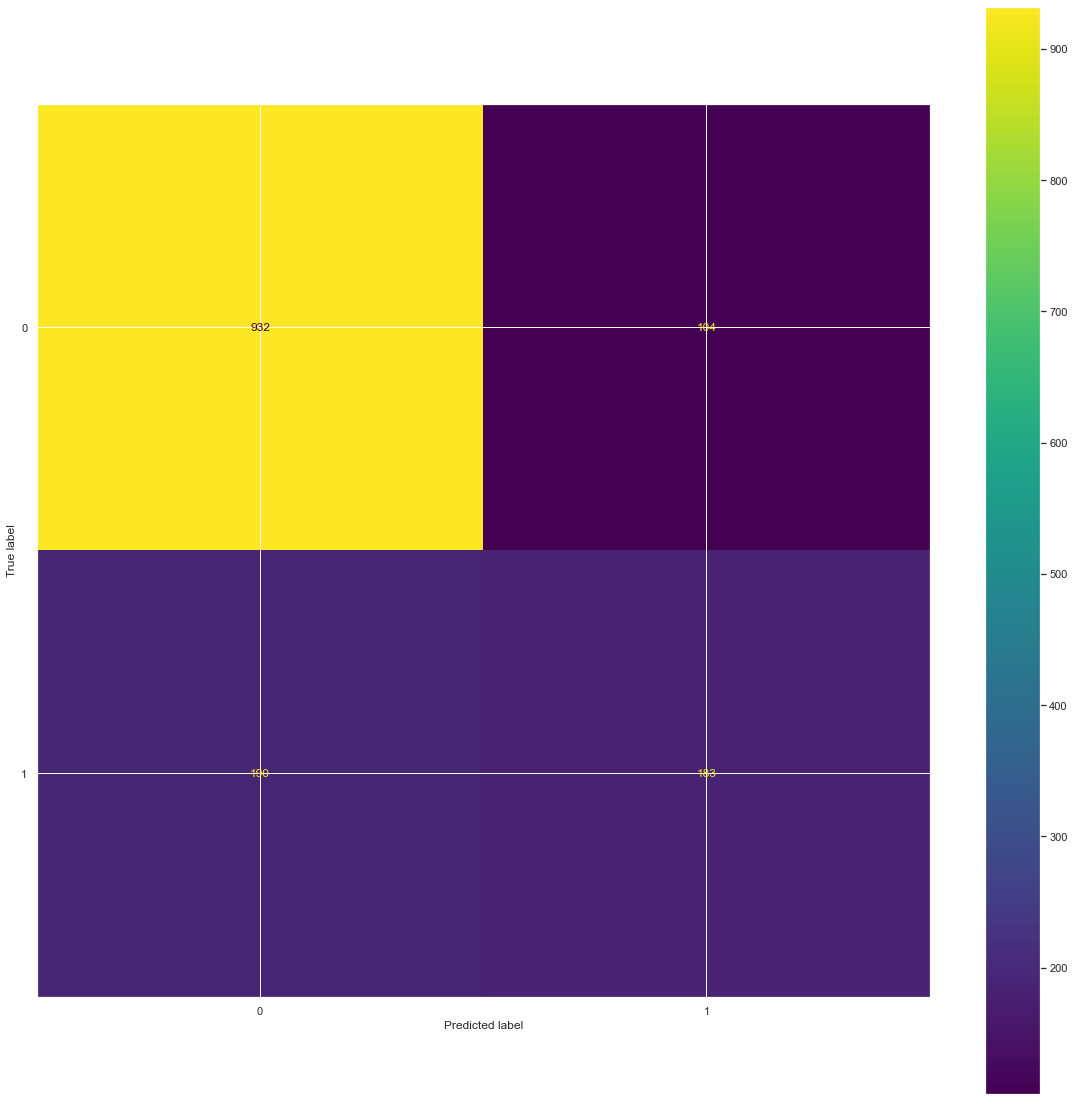

In [110]:
cm_graph = confusion_matrix(y_test, preds)
cm_display = ConfusionMatrixDisplay(cm_graph).plot()

# TRAINING DATASET
## Preparing the data


In [111]:
#Here i applied what i learned from the classes. For this i created 2 files with sellected attributes: tenure,Contract
#PaymentMethod, Churn, TotalCharges.

#file1: telco_test.csv
#file2: telco_training.csv

In [112]:
#create spark context

tel_training = sqlCtx.read.option('header', 'true').options(delimiter=",").csv('telco_training.csv')
print("column types:", tel_training.dtypes)

# I used withColumn() to convert the data type of a DataFrame column,
# This function takes column name I wanted to convert as a first argument and
# for the second argument apply the casting method cast() with DataType on the column.

tel_training = tel_training.withColumn("TotalCharges",func.col("TotalCharges").cast(DoubleType()))
print("column types: ", tel_training.dtypes)

#here i showed the data
tel_training.show(10)


column types: [('tenure', 'string'), ('Contract', 'string'), ('PaymentMethod', 'string'), ('Churn', 'string'), ('TotalCharges', 'string')]
column types:  [('tenure', 'string'), ('Contract', 'string'), ('PaymentMethod', 'string'), ('Churn', 'string'), ('TotalCharges', 'double')]
+------+--------------+--------------------+-----+------------+
|tenure|      Contract|       PaymentMethod|Churn|TotalCharges|
+------+--------------+--------------------+-----+------------+
|     1|Month-to-month|    Electronic check|   No|       29.85|
|    34|      One year|        Mailed check|   No|      1889.5|
|     2|Month-to-month|        Mailed check|  Yes|      108.15|
|    45|      One year|Bank transfer (au...|   No|     1840.75|
|     2|Month-to-month|    Electronic check|  Yes|      151.65|
|     8|Month-to-month|    Electronic check|  Yes|       820.5|
|    22|Month-to-month|Credit card (auto...|   No|      1949.4|
|    10|Month-to-month|        Mailed check|   No|       301.9|
|    28|Month-to-

In [113]:
tel_training = tel_training.withColumn("tenure",func.col("tenure").cast(DoubleType()))
print("column types: ", tel_training.dtypes)

tel_training.show(10)

column types:  [('tenure', 'double'), ('Contract', 'string'), ('PaymentMethod', 'string'), ('Churn', 'string'), ('TotalCharges', 'double')]
+------+--------------+--------------------+-----+------------+
|tenure|      Contract|       PaymentMethod|Churn|TotalCharges|
+------+--------------+--------------------+-----+------------+
|   1.0|Month-to-month|    Electronic check|   No|       29.85|
|  34.0|      One year|        Mailed check|   No|      1889.5|
|   2.0|Month-to-month|        Mailed check|  Yes|      108.15|
|  45.0|      One year|Bank transfer (au...|   No|     1840.75|
|   2.0|Month-to-month|    Electronic check|  Yes|      151.65|
|   8.0|Month-to-month|    Electronic check|  Yes|       820.5|
|  22.0|Month-to-month|Credit card (auto...|   No|      1949.4|
|  10.0|Month-to-month|        Mailed check|   No|       301.9|
|  28.0|Month-to-month|    Electronic check|  Yes|     3046.05|
|  62.0|      One year|Bank transfer (au...|   No|     3487.95|
+------+--------------+-----

In [114]:

ContractIndexer = StringIndexer(inputCol="Contract", outputCol="ContractFeature")

#here i am running the indexer.
#I used .fit to run ContractIndexer on my training dataset
ContractIndexer_fit = ContractIndexer.fit(tel_training)

#Transformer : is an algorithm which can transform one DataFrame into another DataFrame,
# E.g., an ML model is a Tranmsfomer which transforms DataFrame with features a DataFrame with predictions.
dataframe_training = ContractIndexer_fit.transform(tel_training)

print(dataframe_training.dtypes)

#Show Data Frame
dataframe_training.show(20)

[('tenure', 'double'), ('Contract', 'string'), ('PaymentMethod', 'string'), ('Churn', 'string'), ('TotalCharges', 'double'), ('ContractFeature', 'double')]
+------+--------------+--------------------+-----+------------+---------------+
|tenure|      Contract|       PaymentMethod|Churn|TotalCharges|ContractFeature|
+------+--------------+--------------------+-----+------------+---------------+
|   1.0|Month-to-month|    Electronic check|   No|       29.85|            0.0|
|  34.0|      One year|        Mailed check|   No|      1889.5|            2.0|
|   2.0|Month-to-month|        Mailed check|  Yes|      108.15|            0.0|
|  45.0|      One year|Bank transfer (au...|   No|     1840.75|            2.0|
|   2.0|Month-to-month|    Electronic check|  Yes|      151.65|            0.0|
|   8.0|Month-to-month|    Electronic check|  Yes|       820.5|            0.0|
|  22.0|Month-to-month|Credit card (auto...|   No|      1949.4|            0.0|
|  10.0|Month-to-month|        Mailed check|

In [115]:
# index Labels, adding metadata to the PaymentMethod column
#i fitted on whole dataset to include all labels in the index.
PaymentMethodIndexer = StringIndexer(inputCol="PaymentMethod", outputCol="PaymentMethodFeature")

#running the indexer
PaymentMethodIndexer_fit = PaymentMethodIndexer.fit(dataframe_training)
dataframe_training = PaymentMethodIndexer_fit.transform(dataframe_training)
print(dataframe_training.dtypes)

#Show Data Frame
dataframe_training.show(10)

[('tenure', 'double'), ('Contract', 'string'), ('PaymentMethod', 'string'), ('Churn', 'string'), ('TotalCharges', 'double'), ('ContractFeature', 'double'), ('PaymentMethodFeature', 'double')]
+------+--------------+--------------------+-----+------------+---------------+--------------------+
|tenure|      Contract|       PaymentMethod|Churn|TotalCharges|ContractFeature|PaymentMethodFeature|
+------+--------------+--------------------+-----+------------+---------------+--------------------+
|   1.0|Month-to-month|    Electronic check|   No|       29.85|            0.0|                 0.0|
|  34.0|      One year|        Mailed check|   No|      1889.5|            2.0|                 1.0|
|   2.0|Month-to-month|        Mailed check|  Yes|      108.15|            0.0|                 1.0|
|  45.0|      One year|Bank transfer (au...|   No|     1840.75|            2.0|                 2.0|
|   2.0|Month-to-month|    Electronic check|  Yes|      151.65|            0.0|                 0.0|


In [116]:
#We do same one for Churn too.

ChurnIndexer = StringIndexer(inputCol="Churn", outputCol="ChurnLabel")

ChurnIndexer_fit = ChurnIndexer.fit(dataframe_training)
dataframe_training = ChurnIndexer_fit.transform(dataframe_training)
print(dataframe_training.dtypes)

dataframe_training.show(10)

[('tenure', 'double'), ('Contract', 'string'), ('PaymentMethod', 'string'), ('Churn', 'string'), ('TotalCharges', 'double'), ('ContractFeature', 'double'), ('PaymentMethodFeature', 'double'), ('ChurnLabel', 'double')]
+------+--------------+--------------------+-----+------------+---------------+--------------------+----------+
|tenure|      Contract|       PaymentMethod|Churn|TotalCharges|ContractFeature|PaymentMethodFeature|ChurnLabel|
+------+--------------+--------------------+-----+------------+---------------+--------------------+----------+
|   1.0|Month-to-month|    Electronic check|   No|       29.85|            0.0|                 0.0|       0.0|
|  34.0|      One year|        Mailed check|   No|      1889.5|            2.0|                 1.0|       0.0|
|   2.0|Month-to-month|        Mailed check|  Yes|      108.15|            0.0|                 1.0|       1.0|
|  45.0|      One year|Bank transfer (au...|   No|     1840.75|            2.0|                 2.0|       0.0

In [117]:
#vector features,
#fit on whole dataset to include all features. it needs to be only two attributes here.

featureAssembler = VectorAssembler(inputCols = ["ContractFeature", "PaymentMethodFeature"], outputCol = 'features')

#featureAssembler is name of variable it transformed the DF that I builded in my training data to demonstrate output.

dataframe_training = featureAssembler.transform(dataframe_training)
dataframe_training.show(5)

+------+--------------+--------------------+-----+------------+---------------+--------------------+----------+---------+
|tenure|      Contract|       PaymentMethod|Churn|TotalCharges|ContractFeature|PaymentMethodFeature|ChurnLabel| features|
+------+--------------+--------------------+-----+------------+---------------+--------------------+----------+---------+
|   1.0|Month-to-month|    Electronic check|   No|       29.85|            0.0|                 0.0|       0.0|(2,[],[])|
|  34.0|      One year|        Mailed check|   No|      1889.5|            2.0|                 1.0|       0.0|[2.0,1.0]|
|   2.0|Month-to-month|        Mailed check|  Yes|      108.15|            0.0|                 1.0|       1.0|[0.0,1.0]|
|  45.0|      One year|Bank transfer (au...|   No|     1840.75|            2.0|                 2.0|       0.0|[2.0,2.0]|
|   2.0|Month-to-month|    Electronic check|  Yes|      151.65|            0.0|                 0.0|       1.0|(2,[],[])|
+------+--------------+-

In [118]:
dataframe_training_output = dataframe_training.select(['ChurnLabel', 'features'])
dataframe_training_output.show(10)

+----------+---------+
|ChurnLabel| features|
+----------+---------+
|       0.0|(2,[],[])|
|       0.0|[2.0,1.0]|
|       1.0|[0.0,1.0]|
|       0.0|[2.0,2.0]|
|       1.0|(2,[],[])|
|       1.0|(2,[],[])|
|       0.0|[0.0,3.0]|
|       0.0|[0.0,1.0]|
|       1.0|(2,[],[])|
|       0.0|[2.0,2.0]|
+----------+---------+
only showing top 10 rows



# TEST DATASET

In [119]:
#create spark context

telco_test = sqlCtx.read.option('header','true').options(delimiter=",").csv('telco_test.csv')

# I used withColumn() to convert the data type of a DataFrame column,
# This function takes column name I wanted to convert as a first argument and
# for the second argument apply the casting method cast() with DataType on the column.


telco_test = telco_test.withColumn("TotalCharges",func.col("TotalCharges").cast(DoubleType()))

print(telco_test.dtypes)

telco_test.show(5)

[('tenure', 'string'), ('Contract', 'string'), ('PaymentMethod', 'string'), ('Churn', 'string'), ('TotalCharges', 'double')]
+------+--------------+--------------------+-----+------------+
|tenure|      Contract|       PaymentMethod|Churn|TotalCharges|
+------+--------------+--------------------+-----+------------+
|     1|Month-to-month|    Electronic check|   No|       29.85|
|    34|      One year|        Mailed check|   No|      1889.5|
|     2|Month-to-month|        Mailed check|  Yes|      108.15|
|    45|      One year|Bank transfer (au...|   No|     1840.75|
|     2|Month-to-month|    Electronic check|  Yes|      151.65|
+------+--------------+--------------------+-----+------------+
only showing top 5 rows



In [120]:
#I did same for the tenure attribute

telco_test = sqlCtx.read.option('header','true').options(delimiter=",").csv('telco_test.csv')
telco_test = telco_test.withColumn("tenure",func.col("tenure").cast(DoubleType()))
telco_test.show(5)
print(telco_test.dtypes)


+------+--------------+--------------------+-----+------------+
|tenure|      Contract|       PaymentMethod|Churn|TotalCharges|
+------+--------------+--------------------+-----+------------+
|   1.0|Month-to-month|    Electronic check|   No|       29.85|
|  34.0|      One year|        Mailed check|   No|      1889.5|
|   2.0|Month-to-month|        Mailed check|  Yes|      108.15|
|  45.0|      One year|Bank transfer (au...|   No|     1840.75|
|   2.0|Month-to-month|    Electronic check|  Yes|      151.65|
+------+--------------+--------------------+-----+------------+
only showing top 5 rows

[('tenure', 'double'), ('Contract', 'string'), ('PaymentMethod', 'string'), ('Churn', 'string'), ('TotalCharges', 'string')]


In [121]:
ChurnIndexer_test = StringIndexer(inputCol="Churn", outputCol="ChurnLabel")

#here i am running the indexer.
#I used .fit to run ChurnIndexer on my test dataset
ChurnIndexer_fit = ChurnIndexer_test.fit(telco_test)

#Transformer : is an algorithm which can transform one DataFrame into another DataFrame,
# E.g., an ML model is a Tranmsfomer which transforms DataFrame with features a DataFrame with predictions.
dataframe_test = ChurnIndexer_fit.transform(telco_test)
print(dataframe_test.dtypes)

dataframe_test.show(5)


[('tenure', 'double'), ('Contract', 'string'), ('PaymentMethod', 'string'), ('Churn', 'string'), ('TotalCharges', 'string'), ('ChurnLabel', 'double')]
+------+--------------+--------------------+-----+------------+----------+
|tenure|      Contract|       PaymentMethod|Churn|TotalCharges|ChurnLabel|
+------+--------------+--------------------+-----+------------+----------+
|   1.0|Month-to-month|    Electronic check|   No|       29.85|       0.0|
|  34.0|      One year|        Mailed check|   No|      1889.5|       0.0|
|   2.0|Month-to-month|        Mailed check|  Yes|      108.15|       1.0|
|  45.0|      One year|Bank transfer (au...|   No|     1840.75|       0.0|
|   2.0|Month-to-month|    Electronic check|  Yes|      151.65|       1.0|
+------+--------------+--------------------+-----+------------+----------+
only showing top 5 rows



In [122]:
#i did same for the Contract feature

ContractIndexer = StringIndexer(inputCol="Contract", outputCol="ContractFeature")
ContractIndexer_fit = ContractIndexer.fit(dataframe_test)
dataframe_test = ContractIndexer_fit.transform(dataframe_test)
dataframe_test.show(5)


+------+--------------+--------------------+-----+------------+----------+---------------+
|tenure|      Contract|       PaymentMethod|Churn|TotalCharges|ChurnLabel|ContractFeature|
+------+--------------+--------------------+-----+------------+----------+---------------+
|   1.0|Month-to-month|    Electronic check|   No|       29.85|       0.0|            0.0|
|  34.0|      One year|        Mailed check|   No|      1889.5|       0.0|            2.0|
|   2.0|Month-to-month|        Mailed check|  Yes|      108.15|       1.0|            0.0|
|  45.0|      One year|Bank transfer (au...|   No|     1840.75|       0.0|            2.0|
|   2.0|Month-to-month|    Electronic check|  Yes|      151.65|       1.0|            0.0|
+------+--------------+--------------------+-----+------------+----------+---------------+
only showing top 5 rows



In [123]:
PaymentMethodIndexer = StringIndexer(inputCol="PaymentMethod", outputCol="PaymentMethodFeature")
PaymentMethodIndexer_fit = PaymentMethodIndexer.fit(dataframe_test)
dataframe_test = PaymentMethodIndexer_fit.transform(dataframe_test)
dataframe_test.show(5)

+------+--------------+--------------------+-----+------------+----------+---------------+--------------------+
|tenure|      Contract|       PaymentMethod|Churn|TotalCharges|ChurnLabel|ContractFeature|PaymentMethodFeature|
+------+--------------+--------------------+-----+------------+----------+---------------+--------------------+
|   1.0|Month-to-month|    Electronic check|   No|       29.85|       0.0|            0.0|                 0.0|
|  34.0|      One year|        Mailed check|   No|      1889.5|       0.0|            2.0|                 1.0|
|   2.0|Month-to-month|        Mailed check|  Yes|      108.15|       1.0|            0.0|                 1.0|
|  45.0|      One year|Bank transfer (au...|   No|     1840.75|       0.0|            2.0|                 2.0|
|   2.0|Month-to-month|    Electronic check|  Yes|      151.65|       1.0|            0.0|                 0.0|
+------+--------------+--------------------+-----+------------+----------+---------------+--------------

In [124]:
TotalChargesIndexer = StringIndexer(inputCol="TotalCharges", outputCol="TotalChargesFeature")
TotalChargesIndexer_fit = TotalChargesIndexer.fit(dataframe_test)
dataframe_test = TotalChargesIndexer_fit.transform(dataframe_test)
dataframe_test.show(5)

+------+--------------+--------------------+-----+------------+----------+---------------+--------------------+-------------------+
|tenure|      Contract|       PaymentMethod|Churn|TotalCharges|ChurnLabel|ContractFeature|PaymentMethodFeature|TotalChargesFeature|
+------+--------------+--------------------+-----+------------+----------+---------------+--------------------+-------------------+
|   1.0|Month-to-month|    Electronic check|   No|       29.85|       0.0|            0.0|                 0.0|             2715.0|
|  34.0|      One year|        Mailed check|   No|      1889.5|       0.0|            2.0|                 1.0|             1759.0|
|   2.0|Month-to-month|        Mailed check|  Yes|      108.15|       1.0|            0.0|                 1.0|              507.0|
|  45.0|      One year|Bank transfer (au...|   No|     1840.75|       0.0|            2.0|                 2.0|             1695.0|
|   2.0|Month-to-month|    Electronic check|  Yes|      151.65|       1.0|  

In [125]:
#vector features,
#fit on whole dataset to include all features. it needs to be only two attributes here.

featureAssembler = VectorAssembler(inputCols = ["ContractFeature", "PaymentMethodFeature"], outputCol = 'features')
dataframe_test= featureAssembler.transform(dataframe_test)
dataframe_test.show(5)

+------+--------------+--------------------+-----+------------+----------+---------------+--------------------+-------------------+---------+
|tenure|      Contract|       PaymentMethod|Churn|TotalCharges|ChurnLabel|ContractFeature|PaymentMethodFeature|TotalChargesFeature| features|
+------+--------------+--------------------+-----+------------+----------+---------------+--------------------+-------------------+---------+
|   1.0|Month-to-month|    Electronic check|   No|       29.85|       0.0|            0.0|                 0.0|             2715.0|(2,[],[])|
|  34.0|      One year|        Mailed check|   No|      1889.5|       0.0|            2.0|                 1.0|             1759.0|[2.0,1.0]|
|   2.0|Month-to-month|        Mailed check|  Yes|      108.15|       1.0|            0.0|                 1.0|              507.0|[0.0,1.0]|
|  45.0|      One year|Bank transfer (au...|   No|     1840.75|       0.0|            2.0|                 2.0|             1695.0|[2.0,2.0]|
|   2.

In [126]:
dataframe_test = dataframe_test.select(['ChurnLabel', 'features'])
dataframe_test.show()
dataframe_training.show()

+----------+---------+
|ChurnLabel| features|
+----------+---------+
|       0.0|(2,[],[])|
|       0.0|[2.0,1.0]|
|       1.0|[0.0,1.0]|
|       0.0|[2.0,2.0]|
|       1.0|(2,[],[])|
|       1.0|(2,[],[])|
|       0.0|[0.0,3.0]|
|       0.0|[0.0,1.0]|
|       1.0|(2,[],[])|
|       0.0|[2.0,2.0]|
|       0.0|[0.0,1.0]|
|       0.0|[1.0,3.0]|
|       0.0|[2.0,3.0]|
|       1.0|[0.0,2.0]|
|       0.0|(2,[],[])|
|       0.0|[1.0,3.0]|
|       0.0|[2.0,1.0]|
|       0.0|[1.0,2.0]|
|       1.0|[0.0,3.0]|
|       0.0|(2,[],[])|
+----------+---------+
only showing top 20 rows

+------+--------------+--------------------+-----+------------+---------------+--------------------+----------+---------+
|tenure|      Contract|       PaymentMethod|Churn|TotalCharges|ContractFeature|PaymentMethodFeature|ChurnLabel| features|
+------+--------------+--------------------+-----+------------+---------------+--------------------+----------+---------+
|   1.0|Month-to-month|    Electronic check|   No|      

In [127]:


# Create DecisionTreeClassifier as i made above in different way
dtc = DecisionTreeClassifier(labelCol="ChurnLabel", featuresCol="features")

# Fitting the dataframe into the DecisionTreeClassifier
dtc = dtc.fit(dataframe_training)

# Making the predictions
pred = dtc.transform(dataframe_test)
pred.show(10)

+----------+---------+--------------+--------------------+----------+
|ChurnLabel| features| rawPrediction|         probability|prediction|
+----------+---------+--------------+--------------------+----------+
|       0.0|(2,[],[])| [856.0,994.0]|[0.46270270270270...|       1.0|
|       0.0|[2.0,1.0]|[2954.0,214.0]|[0.93244949494949...|       0.0|
|       1.0|[0.0,1.0]|[1364.0,661.0]|[0.67358024691358...|       0.0|
|       0.0|[2.0,2.0]|[2954.0,214.0]|[0.93244949494949...|       0.0|
|       1.0|(2,[],[])| [856.0,994.0]|[0.46270270270270...|       1.0|
|       1.0|(2,[],[])| [856.0,994.0]|[0.46270270270270...|       1.0|
|       0.0|[0.0,3.0]|[1364.0,661.0]|[0.67358024691358...|       0.0|
|       0.0|[0.0,1.0]|[1364.0,661.0]|[0.67358024691358...|       0.0|
|       1.0|(2,[],[])| [856.0,994.0]|[0.46270270270270...|       1.0|
|       0.0|[2.0,2.0]|[2954.0,214.0]|[0.93244949494949...|       0.0|
+----------+---------+--------------+--------------------+----------+
only showing top 10 

# Precision

In [128]:
#True Positive (TP) - label is positive and prediction is also positive
#True Negative (TN) - label is negative and prediction is also negative
#False Positive (FP) - label is negative but prediction is positive
#False Negative (FN) - label is positive but prediction is negative

tp = pred.filter((pred.ChurnLabel == 1) & (pred.prediction == 1)).count()
tn = pred.filter((pred.ChurnLabel == 0) & (pred.prediction == 0)).count()
fp = pred.filter((pred.ChurnLabel == 0) & (pred.prediction == 1)).count()
fn = pred.filter((pred.ChurnLabel == 1) & (pred.prediction == 0)).count()

print("True Positives:", tp)
print("True Negatives:", tn)
print("False Positives:", fp)
print("False Negatives:", fn)


#>>F1: The harmonic mean of recall and accuracy is the F1 score. It is a statistical metric used to evaluate productivity. 
#A n F1-score is a mean of a person's actions based on two elements, namely accuracy and recall 
#(from 0 to 9, with 0 being the lowest and 9 the most).

a = ((tp + tn)/pred.count())
r = float(tp) / (tp + fn)
p = float(tp) / (tp + fp)
f1 = 2 * ((p * r)/(p + r))

print("Accuracy:", a)
print("Recall:", r)
print("Precision:", p)
print("F1 score:", f1)

True Positives: 994
True Negatives: 4318
False Positives: 856
False Negatives: 875
Accuracy: 0.7542240522504614
Recall: 0.5318352059925093
Precision: 0.5372972972972972
F1 score: 0.5345522990051089
